# Organize the data Directory

In [97]:
import os
import shutil
import re

In [95]:
!unzip data.zip

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [98]:
# Directory containing our images
data_dir = 'data'

# Directory containing our training images
train_dir = './data/train'
train_dogs_dir = f'{train_dir}/dog'
train_cats_dir = f'{train_dir}/cat'

# Directory containing our validation images
val_dir = "./data/val"
val_dogs_dir = f'{val_dir}/dog'
val_cats_dir = f'{val_dir}/cat'

# Directory containing our test images
test_dir = './data/testset/test'


In [99]:
# Create Dog validation directory and move validation images
dog_files = os.listdir(train_dogs_dir)

for f in dog_files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)

# Create Cat validation directory and move validation images
cat_files = os.listdir(train_cats_dir)
for f in cat_files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)

# Data Preprocessing

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import math

In [110]:
# Compose the different transforms we will be applying to our images
tsfrm = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [111]:
# Create the Dataset object and wrap the object with a Dataloader
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              tsfrm[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=56,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}

# Verify dataloader is correct by checking size and class name
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes
print(class_names) 
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


['Cat', 'Dog']
Train image size: 17998
Validation image size: 2000


In [112]:
def imshow(img, title=None):
    """Imshow for our Images.
    The title will be made of 0 (cats) and 1 (dogs)"""
    # Convert to numpy
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
        

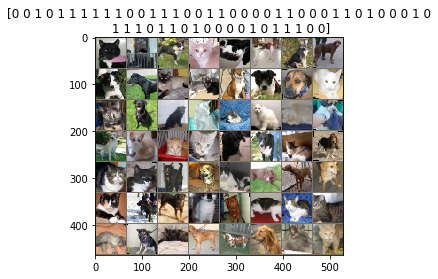

In [113]:
# Get a batch (based on batch size set in Dataloader) of training data
inputs, classes = next(iter(dataloaders['train']))
labels = classes.numpy()

# Make a grid and show images
samples = torchvision.utils.make_grid(inputs)
imshow(samples, title=labels)



In [114]:
# Check shape is correct (First number should be batch size, then 3, 64, 64)
print(inputs.shape)

torch.Size([56, 3, 64, 64])


# Training 

In [27]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # 3 x 64 x 64 -> 6 x 60 x 60
        x = self.pool(x)            # 6 x 60 x 60 -> 6 x 30 x 30
        x = F.relu(self.conv2(x))   # 6 x 30 x 30 -> 16 x 24 x 24
        x = self.pool(x)            # 16 x 24 x 24 -> 16 x 12 x 12
        x = x.view(-1, 16 * 12 * 12)  # flatten
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
def train_model(model, criterion, optimizer, num_epochs=5, checkpoint=None):
    since = time.time()
    
    # Check if checkpoint available. 
    print(checkpoint)
    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        # If checkpoint exists, start from last checkpoint and load checkpoint state.
        print('Val loss: {}, Val accuracy: {}'.format(checkpoint['best_val_loss'], checkpoint['best_val_accuracy']))
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    # Create list for storing losses for plotting use
    val_loss_list = []
    train_loss_list = []
    val_acc_list = []
    train_acc_list = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        

        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            

            running_loss = 0.
            running_corrects = 0
              
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
    
                # Print every 500 images
                if i % 500 == 499:
                    print('[%d, %d] loss: %.3f' % (epoch + 1, i, running_loss / (i * inputs.size(0))))
                    
                # Forward pass (track only if training)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass (optimize only if training)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            

            # Get loss and accuracy for epochs
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            if phase == 'val':
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            # Make a deep copy of the best model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # Load weights of resulting best model
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list
            

# Utils for visualization of model and learning curves

In [29]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images += 1
                ax = plt.subplot(num_images//2, 2, images)
                ax.axis('off')
                ax.set_title('Prediction: {}'.format(class_names[predictions[j]]))
                imshow(inputs.cpu().data[j])

                if images == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [30]:
def plot_learning_curve(train_acc, val_acc, name):
    plt.plot(train_acc, label='Training')
    plt.plot(val_acc, label='Validation')
    
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    
    plt.legend()
    plt.savefig('acc_{}.png'.format(name))
    plt.show()

In [31]:
def plot_loss_curve(train_loss, val_loss, name):
    plt.plot(train_loss, label='Training')
    plt.plot(val_loss, label='Validation')
    
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    
    plt.legend()
    plt.savefig('loss_{}.png'.format(name))
    plt.show()

# Models

### Best Model

In [32]:
# Initialize model and hyperparameters
CHECKPOINT = 'checkpoint_model_1.tar'
model_1 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001)
num_epochs = 25

model_1 = model_1.to(device)

In [33]:
try:
    checkpoint = torch.load(CHECKPOINT)
    print("Checkpoint Found")
except:
    checkpoint = None
    print("Checkpoint Not Found")
    

model_1, best_val_loss, best_val_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_model(model_1,
                                                              criterion,
                                                              optimizer,
                                                              num_epochs,
                                                              checkpoint = checkpoint)
torch.save({'model_state_dict': model_1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'train_loss_list': train_loss_list,
            'val_loss_list': val_loss_list, 
            'train_acc_list': train_acc_list,
            'val_acc_list': val_acc_list
            }, CHECKPOINT)

Checkpoint Not Found
None
Epoch 0/24
----------
[1, 499] loss: 0.694
[1, 999] loss: 0.693
[1, 1499] loss: 0.692
[1, 1999] loss: 0.691
[1, 2499] loss: 0.690
[1, 2999] loss: 0.689
[1, 3499] loss: 0.687
[1, 3999] loss: 0.686
[1, 4499] loss: 1.369
train Loss: 0.6845 Acc: 0.5646
[1, 499] loss: 0.674
val Loss: 0.6735 Acc: 0.5855
New best model found!
New record loss: 0.6735217480063438, previous record loss: inf

Epoch 1/24
----------
[2, 499] loss: 0.666
[2, 999] loss: 0.666
[2, 1499] loss: 0.666
[2, 1999] loss: 0.662
[2, 2499] loss: 0.662
[2, 2999] loss: 0.658
[2, 3499] loss: 0.658
[2, 3999] loss: 0.658
[2, 4499] loss: 1.313
train Loss: 0.6565 Acc: 0.6127
[2, 499] loss: 0.641
val Loss: 0.6410 Acc: 0.6480
New best model found!
New record loss: 0.6410214935541153, previous record loss: 0.6735217480063438

Epoch 2/24
----------
[3, 499] loss: 0.647
[3, 999] loss: 0.644
[3, 1499] loss: 0.641
[3, 1999] loss: 0.640
[3, 2499] loss: 0.640
[3, 2999] loss: 0.640
[3, 3499] loss: 0.639
[3, 3999] loss:

[23, 499] loss: 0.396
[23, 999] loss: 0.402
[23, 1499] loss: 0.401
[23, 1999] loss: 0.400
[23, 2499] loss: 0.399
[23, 2999] loss: 0.401
[23, 3499] loss: 0.400
[23, 3999] loss: 0.401
[23, 4499] loss: 0.802
train Loss: 0.4011 Acc: 0.8163
[23, 499] loss: 0.510
val Loss: 0.5091 Acc: 0.7565

Epoch 23/24
----------
[24, 499] loss: 0.402
[24, 999] loss: 0.394
[24, 1499] loss: 0.397
[24, 1999] loss: 0.397
[24, 2499] loss: 0.395
[24, 2999] loss: 0.395
[24, 3499] loss: 0.395
[24, 3999] loss: 0.394
[24, 4499] loss: 0.785
train Loss: 0.3926 Acc: 0.8250
[24, 499] loss: 0.480
val Loss: 0.4811 Acc: 0.7820

Epoch 24/24
----------
[25, 499] loss: 0.374
[25, 999] loss: 0.375
[25, 1499] loss: 0.377
[25, 1999] loss: 0.377
[25, 2499] loss: 0.380
[25, 2999] loss: 0.384
[25, 3499] loss: 0.384
[25, 3999] loss: 0.382
[25, 4499] loss: 0.763
train Loss: 0.3817 Acc: 0.8281
[25, 499] loss: 0.486
val Loss: 0.4861 Acc: 0.7735

Training complete in 23m 28s
Best val Acc: 0.7845 Best val loss: 0.4612


### Question 1: Describe Architecture

In [35]:
# Model Parameters
model_1

Simple_CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Question 2: Training and Validation Error Curves

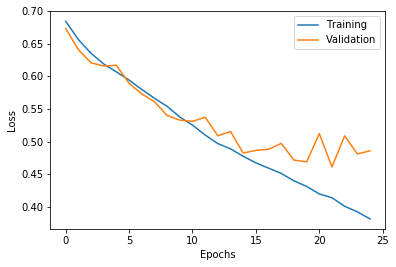

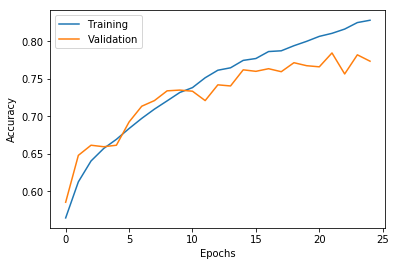

Best Accuracy  :  0.7845
Best Loss      :  0.4612441785335541


In [38]:
plot_loss_curve(train_loss_list, val_loss_list, 'model_1')
plot_learning_curve(train_acc_list, val_acc_list, 'model_1')

print('Best Accuracy  : ', best_val_acc.numpy())
print('Best Loss      : ', best_val_loss)

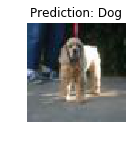

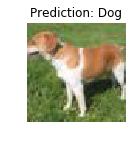

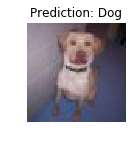

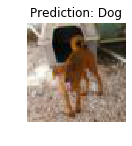

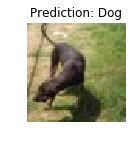

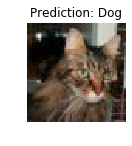

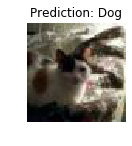

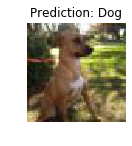

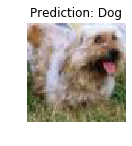

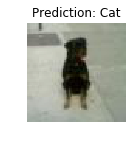

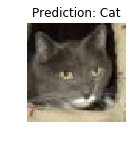

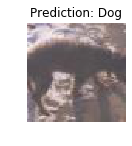

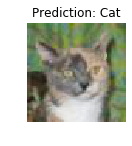

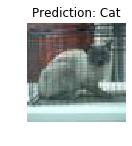

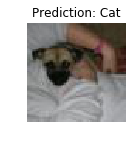

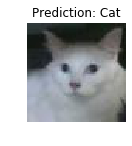

In [39]:
# Print some example of images and label predictions
visualize_model(model_1, 4)
visualize_model(model_1, 4)
visualize_model(model_1, 4)
visualize_model(model_1, 4)

plt.ioff()
plt.show()

### Question 3: Hyperparameters

#### Increasing Learning Rate

In [84]:
checkpoint_2 = 'checkpoint_2.tar'
model_2 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.099)
num_epochs = 20
model_2 = model_2.to(device)

try:
    checkpoint = torch.load(checkpoint_2)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")


model_2, best_val_loss, best_val_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_model(model_2, criterion, optimizer, num_epochs, checkpoint = checkpoint)

torch.save({'model_state_dict': model_2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'train_loss_list': train_loss_list,
            'val_loss_list': val_loss_list, 
            'train_acc_list': train_acc_list,
            'val_acc_list': val_acc_list
            },  checkpoint_2)

checkpoint not found
None
Epoch 0/19
----------
[1, 499] loss: 0.700
[1, 999] loss: 0.697
[1, 1499] loss: 0.696
[1, 1999] loss: 0.698
[1, 2499] loss: 0.697
[1, 2999] loss: 0.697
[1, 3499] loss: 0.696
[1, 3999] loss: 0.695
[1, 4499] loss: 1.389
train Loss: 0.6945 Acc: 0.5202
[1, 499] loss: 0.681
val Loss: 0.6807 Acc: 0.5765
New best model found!
New record loss: 0.6806882586479187, previous record loss: inf

Epoch 1/19
----------
[2, 499] loss: 0.687
[2, 999] loss: 0.686
[2, 1499] loss: 0.688
[2, 1999] loss: 0.687
[2, 2499] loss: 0.688
[2, 2999] loss: 0.687
[2, 3499] loss: 0.685
[2, 3999] loss: 0.683
[2, 4499] loss: 1.364
train Loss: 0.6821 Acc: 0.5729
[2, 499] loss: 0.655
val Loss: 0.6551 Acc: 0.6125
New best model found!
New record loss: 0.6551037689447403, previous record loss: 0.6806882586479187

Epoch 2/19
----------
[3, 499] loss: 0.681
[3, 999] loss: 0.682
[3, 1499] loss: 0.679
[3, 1999] loss: 0.677
[3, 2499] loss: 0.680
[3, 2999] loss: 0.682
[3, 3499] loss: 0.680
[3, 3999] loss:

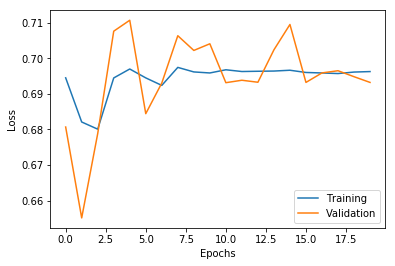

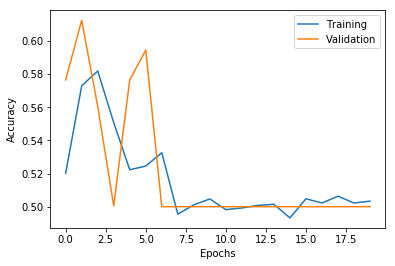

INCREASING LEARNING RATE
Best Accuracy  :  0.6125
Best Loss      :  0.6551037689447403


In [85]:
plot_loss_curve(train_loss_list, val_loss_list, 'model_2')
plot_learning_curve(train_acc_list, val_acc_list, 'model_2')

print('INCREASING LEARNING RATE')
print('Best Accuracy  : ', best_val_acc.numpy())
print('Best Loss      : ', best_val_loss)

We can see that by increasing the learning rate our loss jumps towards and away from a optimum or a local optima. The fluctuations in the learning curves shows how it fails to converge. The accuracy with a learning rate of 0.5 is %0.6125 vs %78.45 for our best model that had a learning rate of 0.001.

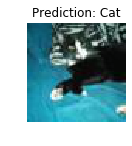

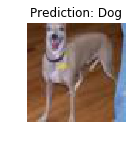

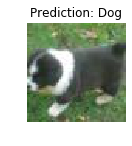

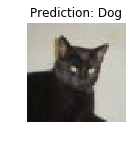

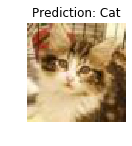

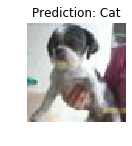

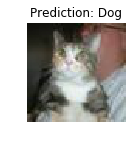

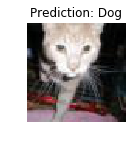

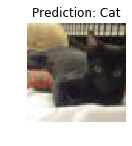

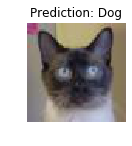

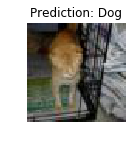

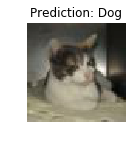

In [86]:
# Print some example of images and label predictions
visualize_model(model_2, 4)
visualize_model(model_2, 4)
visualize_model(model_2, 4)

plt.ioff()
plt.show()


#### Decreasing Learning Rate

In [57]:
checkpoint_3 = 'checkpoint_3.tar'
model_3 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.0001)
num_epochs = 50
model_3 = model_3.to(device)

try:
    checkpoint = torch.load(checkpoint_3)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")


model_3, best_val_loss, best_val_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_model(model_3, criterion, optimizer, num_epochs, checkpoint = checkpoint)

torch.save({'model_state_dict': model_3.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'train_loss_list': train_loss_list,
            'val_loss_list': val_loss_list, 
            'train_acc_list': train_acc_list,
            'val_acc_list': val_acc_list
            },checkpoint_3)

checkpoint not found
None
Epoch 0/49
----------
[1, 499] loss: 0.693
[1, 999] loss: 0.693
[1, 1499] loss: 0.693
[1, 1999] loss: 0.693
[1, 2499] loss: 0.693
[1, 2999] loss: 0.693
[1, 3499] loss: 0.693
[1, 3999] loss: 0.693
[1, 4499] loss: 1.386
train Loss: 0.6927 Acc: 0.5214
[1, 499] loss: 0.692
val Loss: 0.6924 Acc: 0.5370
New best model found!
New record loss: 0.6923839069604873, previous record loss: inf

Epoch 1/49
----------
[2, 499] loss: 0.692
[2, 999] loss: 0.692
[2, 1499] loss: 0.692
[2, 1999] loss: 0.692
[2, 2499] loss: 0.692
[2, 2999] loss: 0.692
[2, 3499] loss: 0.692
[2, 3999] loss: 0.692
[2, 4499] loss: 1.384
train Loss: 0.6922 Acc: 0.5493
[2, 499] loss: 0.692
val Loss: 0.6918 Acc: 0.5510
New best model found!
New record loss: 0.6918310774564743, previous record loss: 0.6923839069604873

Epoch 2/49
----------
[3, 499] loss: 0.692
[3, 999] loss: 0.692
[3, 1499] loss: 0.692
[3, 1999] loss: 0.692
[3, 2499] loss: 0.692
[3, 2999] loss: 0.692
[3, 3499] loss: 0.692
[3, 3999] loss:

[21, 3999] loss: 0.633
[21, 4499] loss: 1.267
train Loss: 0.6333 Acc: 0.6465
[21, 499] loss: 0.631
val Loss: 0.6312 Acc: 0.6445
New best model found!
New record loss: 0.6311764562726021, previous record loss: 0.6382148985266686

Epoch 21/49
----------
[22, 499] loss: 0.639
[22, 999] loss: 0.636
[22, 1499] loss: 0.633
[22, 1999] loss: 0.631
[22, 2499] loss: 0.628
[22, 2999] loss: 0.628
[22, 3499] loss: 0.627
[22, 3999] loss: 0.628
[22, 4499] loss: 1.256
train Loss: 0.6278 Acc: 0.6520
[22, 499] loss: 0.633
val Loss: 0.6326 Acc: 0.6440

Epoch 22/49
----------
[23, 499] loss: 0.620
[23, 999] loss: 0.623
[23, 1499] loss: 0.625
[23, 1999] loss: 0.627
[23, 2499] loss: 0.626
[23, 2999] loss: 0.624
[23, 3499] loss: 0.623
[23, 3999] loss: 0.623
[23, 4499] loss: 1.246
train Loss: 0.6229 Acc: 0.6562
[23, 499] loss: 0.625
val Loss: 0.6255 Acc: 0.6465
New best model found!
New record loss: 0.6254839956760406, previous record loss: 0.6311764562726021

Epoch 23/49
----------
[24, 499] loss: 0.618
[24,

[43, 999] loss: 0.559
[43, 1499] loss: 0.559
[43, 1999] loss: 0.558
[43, 2499] loss: 0.558
[43, 2999] loss: 0.559
[43, 3499] loss: 0.559
[43, 3999] loss: 0.560
[43, 4499] loss: 1.121
train Loss: 0.5603 Acc: 0.7141
[43, 499] loss: 0.558
val Loss: 0.5581 Acc: 0.7150
New best model found!
New record loss: 0.5581248178780079, previous record loss: 0.558689315199852

Epoch 43/49
----------
[44, 499] loss: 0.542
[44, 999] loss: 0.547
[44, 1499] loss: 0.552
[44, 1999] loss: 0.554
[44, 2499] loss: 0.559
[44, 2999] loss: 0.559
[44, 3499] loss: 0.559
[44, 3999] loss: 0.559
[44, 4499] loss: 1.118
train Loss: 0.5589 Acc: 0.7131
[44, 499] loss: 0.563
val Loss: 0.5627 Acc: 0.7125

Epoch 44/49
----------
[45, 499] loss: 0.553
[45, 999] loss: 0.555
[45, 1499] loss: 0.557
[45, 1999] loss: 0.555
[45, 2499] loss: 0.558
[45, 2999] loss: 0.558
[45, 3499] loss: 0.557
[45, 3999] loss: 0.557
[45, 4499] loss: 1.117
train Loss: 0.5584 Acc: 0.7149
[45, 499] loss: 0.557
val Loss: 0.5568 Acc: 0.7170
New best model

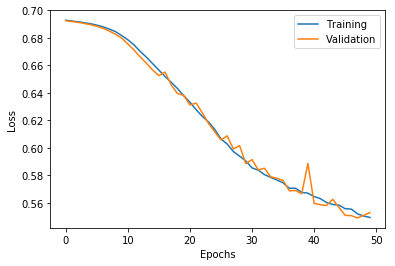

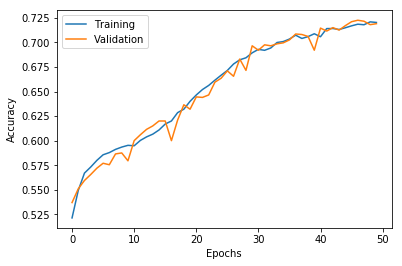

DECREASING LEARNING RATE
Best Accuracy  :  0.7215
Best Loss      :  0.5491218154728412


In [58]:
plot_loss_curve(train_loss_list, val_loss_list, 'model_3')
plot_learning_curve(train_acc_list, val_acc_list, 'model_3')

print('DECREASING LEARNING RATE')
print('Best Accuracy  : ', best_val_acc.numpy())
print('Best Loss      : ', best_val_loss)

We can see that by decreasing the learning rate, our model can seem to converge quickly enough. The accuracy with a learning rate of 0.0001 is %72.15 vs %78.45 for our best model that had a learning rate of 0.001.

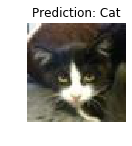

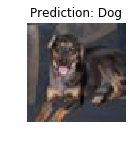

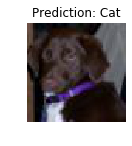

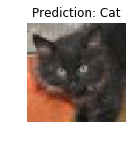

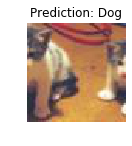

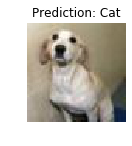

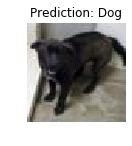

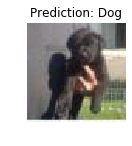

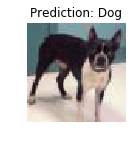

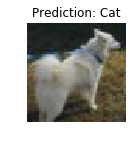

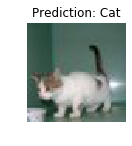

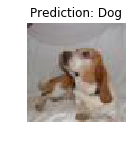

In [62]:
# Print some example of images and label predictions
visualize_model(model_3, 4)
visualize_model(model_3, 4)
visualize_model(model_3, 4)

plt.ioff()
plt.show()

#### Increasing Batch Size

In [115]:
checkpoint_4 = 'checkpoint_4.tar'
model_4 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.001)
num_epochs = 25
model_4 = model_4.to(device)

try:
    checkpoint = torch.load(checkpoint_4)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")


model_4, best_val_loss, best_val_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_model(model_4, criterion,optimizer,num_epochs,checkpoint = checkpoint)

torch.save({'model_state_dict': model_4.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'train_loss_list': train_loss_list,
            'val_loss_list': val_loss_list, 
            'train_acc_list': train_acc_list,
            'val_acc_list': val_acc_list
            }, checkpoint_4)

checkpoint not found
None
Epoch 0/24
----------
train Loss: 0.6931 Acc: 0.5000
val Loss: 0.6925 Acc: 0.5005
New best model found!
New record loss: 0.6925166583061219, previous record loss: inf

Epoch 1/24
----------
train Loss: 0.6923 Acc: 0.5015
val Loss: 0.6918 Acc: 0.5090
New best model found!
New record loss: 0.6917578094005584, previous record loss: 0.6925166583061219

Epoch 2/24
----------
train Loss: 0.6914 Acc: 0.5156
val Loss: 0.6909 Acc: 0.5170
New best model found!
New record loss: 0.6908941900730133, previous record loss: 0.6917578094005584

Epoch 3/24
----------
train Loss: 0.6907 Acc: 0.5343
val Loss: 0.6899 Acc: 0.5495
New best model found!
New record loss: 0.6899023914337158, previous record loss: 0.6908941900730133

Epoch 4/24
----------
train Loss: 0.6896 Acc: 0.5505
val Loss: 0.6887 Acc: 0.5630
New best model found!
New record loss: 0.6887358660697938, previous record loss: 0.6899023914337158

Epoch 5/24
----------
train Loss: 0.6884 Acc: 0.5568
val Loss: 0.6874 Acc:

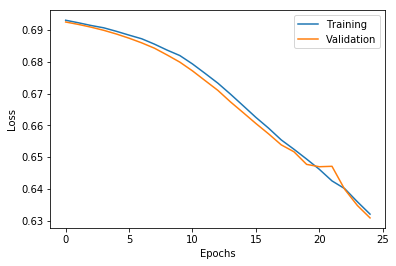

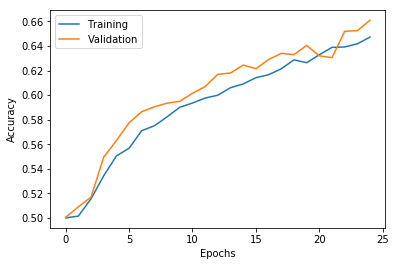

INCREASING BATCH SIZE
Best Accuracy  :  0.661
Best Loss      :  0.6308428497314453


In [117]:
plot_loss_curve(train_loss_list, val_loss_list, 'model_4')
plot_learning_curve(train_acc_list, val_acc_list, 'model_4')

print('INCREASING BATCH SIZE')
print('Best Accuracy  : ', best_val_acc.numpy())
print('Best Loss      : ', best_val_loss)

From the learning curves we see that it converges, but it does not diverge to suggest that we are heading in a zone of overfitting.  Further, the accuracy was not as good as our best model.

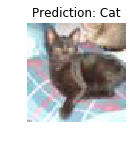

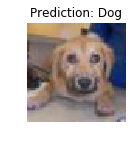

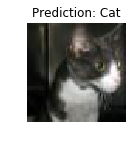

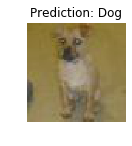

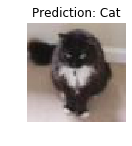

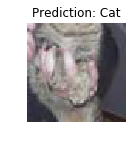

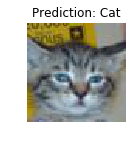

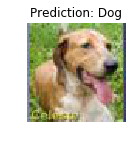

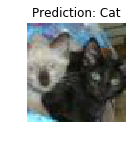

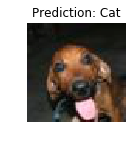

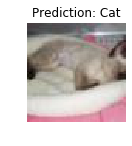

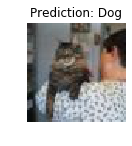

In [118]:
# Print some example of images and label predictions
visualize_model(model_4, 4)
visualize_model(model_4, 4)
visualize_model(model_4, 4)

plt.ioff()
plt.show()

# Apply best model on test set and prepare data for submission

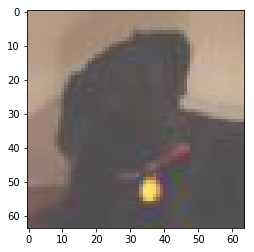

In [48]:
from PIL import Image

# Take images from test directory
test_files = os.listdir(test_dir)
img = Image.open(f'{test_dir}/{test_files[4]}')
plt.imshow(img)

In [49]:
def test_transforms(image):
    # Transforms to apply on test set
    img = transforms.functional.resize(image, [64,64])
    img = transforms.functional.to_tensor(img)
    img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return img

In [67]:
def get_file(fname):
    # Get file from filename
    print("Get File " + fname)
    return int(re.search('\d+', fname).group())

In [66]:
def prediction(model, fname):
    # Force image to be converted in RGB space. 
    # NOTE: 2 images in the test dataset are in the Gray space.
    img = Image.open(f'{test_dir}/{fname}')
    img = img.convert('RGB')

    # Apply transforms to test images
    img_tensor = test_transforms(img)
    minibatch = torch.stack([img_tensor])

    # Perform softmax probability on output layer
    softmax = nn.Softmax(dim = 1)
    prob = softmax(model(minibatch))
    prob_np = prob.detach().numpy()
    
    # Convert to 'Cat' or 'Dog'
    pred = np.argmax(prob_np)
    if pred == 0:
        return 'Cat'
    if pred == 1:
        return 'Dog'
    return predictions[0,1]

In [34]:
model_1.eval()
predictions = {get_file(fname):
    prediction(model_1, fname) for fname in test_files}


In [69]:
import pandas as pd

ds = pd.Series({id : label for (id, label) in zip(predictions.keys(), predictions.values())})
ds.head()

63      Dog
823     Dog
4217    Dog
3578    Dog
2666    Dog
dtype: object

In [ ]:
SUBMISSION_FILE = 'submission2.csv'

In [71]:
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head()

,id,label
1,1,Cat
2,2,Dog
3,3,Cat
4,4,Dog
5,5,Cat


In [72]:
df.to_csv(SUBMISSION_FILE, index = False)